In [456]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# Saves model as file
import pickle
# Verify computational environment
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
# Outlier detection
from sklearn.ensemble import IsolationForest

In [457]:
# Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [458]:
# Import data to google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [459]:
# Verify GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17839670704884365514, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14100077527878823060
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8365057245607729415
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10385897261651684216
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [460]:
# Load data
path = "/content/gdrive/My Drive/Colab Notebooks/data/complete_data.csv"
data = pd.read_csv(path).iloc[:, 4: ]
data.head()

,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,car_friendly,historic,quiet,elementary_schools,high_schools,parks,nightlife,groceries,daycares,pedestrian_friendly,cafes,transit_friendly,greenery,year_built,population_2016_,population_variation_between_2011_2016_,population_density_,unemployment_rate_2016_,"less_than_$50,000_(%)","between_$50,000_and_$80,000_(%)","between_$80,000_and_$100,000_(%)","between_$100,000_and_$150,000_(%)","more_than_$150,000_(%)",1-person_households_(%),2-person_households_(%),3-person_households_(%),4-person_households_(%),5-person_or_more_households_(%),couples_without_children_at_home_(%),couples_with_children_at_home_(%),single-parent_families_(%),owners_(%),renters_(%),before_1960_(%),between_1961_and_1980_(%),between_1981_and_1990_(%),between_1991_and_2000_(%),between_2001_and_2010_(%),between_2011_and_2016_(%),single-family_homes_(%),semi-detached_or_row_houses_(%),buildings_with_less_than_5_floors_(%),buildings_with_5_or_more_floors_(%),mobile_homes_(%),university_(%),college_(%),secondary_(high)_school_(%),apprentice_or_trade_school_diploma_(%),no_diploma_(%),non-immigrant_population_(%),immigrant_population_(%),french_(%),english_(%),others_languages_(%),walk_score,rooms,bedrooms,basement_bedroom,bathrooms,powder_rooms,total_area,new_area_from_price,new_area_from_rooms,river_proximity,has_pool,n_parking,has_garage,is_devided,mr_distance
0,409000,45.5,-73.6,7.0,8.0,5.0,9.0,6.0,5.0,8.0,10.0,7.0,10,3.0,9.0,9.0,10.0,5.0,8.0,5.0,2008.0,69229,5,7181,8,45,22,9,12,11,42,34,13,8,3,46,36,18,37,63,46,21,13,8,9,4,3,7,69,21,0,43,16,18,9,14,75,25,64.0,22.0,14.0,80.0,8.0,2.0,False,1.0,0.0,1014.0,1014.0,1014.0,False,False,1.0,True,1,5.7
1,680000,45.4,-73.6,3.0,3.0,1.0,7.0,10.0,0.0,10.0,7.0,0.0,8,0.0,2.0,4.0,3.0,1.0,4.0,5.0,2006.0,69229,5,7181,8,45,22,9,12,11,42,34,13,8,3,46,36,18,37,63,46,21,13,8,9,4,3,7,69,21,0,43,16,18,9,14,75,25,64.0,22.0,14.0,11.0,6.0,3.0,False,2.0,0.0,1249.0,1249.0,1249.0,False,True,2.0,True,1,7.1
2,283000,45.5,-73.6,8.0,10.0,5.0,3.0,6.0,2.0,0.0,9.0,7.0,8,4.0,10.0,6.0,8.0,6.0,9.0,4.0,2007.0,134245,6,5545,10,49,23,9,11,9,41,27,13,12,7,34,46,20,39,61,37,33,14,6,6,4,9,5,73,13,0,36,16,20,10,17,59,41,65.0,10.0,25.0,72.0,6.0,2.0,False,1.0,0.0,848.0,848.0,848.0,False,False,1.0,True,1,5.2
3,339000,45.5,-73.6,10.0,10.0,9.0,9.0,5.0,6.0,7.0,7.0,4.0,10,9.0,10.0,8.0,10.0,10.0,9.0,5.0,2013.0,80153,9,5070,8,50,22,9,11,7,46,32,11,7,4,44,32,24,35,65,43,18,11,5,10,13,2,7,71,20,0,38,16,19,9,18,74,26,59.0,26.0,15.0,70.0,4.0,1.0,False,1.0,0.0,621.0,621.0,621.0,False,True,0.0,False,1,3.3
4,177800,45.6,-73.6,6.0,7.0,3.0,4.0,9.0,0.0,6.0,4.0,5.0,8,3.0,9.0,2.0,7.0,4.0,7.0,5.0,1993.0,42796,2,3103,10,45,26,10,12,7,38,31,13,12,7,38,41,21,44,56,15,49,16,10,10,1,8,9,65,18,0,25,17,23,14,20,66,34,76.0,8.0,16.0,53.0,6.0,1.0,False,1.0,0.0,586.0,586.0,586.0,False,False,1.0,False,1,11.3


In [461]:
# Transform is_devided into boolean feature
data.is_devided = data.is_devided.astype('bool')

In [462]:
# # Drop redundant data
# redundant = ['more_than_$150,000_(%)', '5-person_or_more_households_(%)', 
#             'single-parent_families_(%)', 'renters_(%)', 'before_1960_(%)',
#             'mobile_homes_(%)', 'university_(%)', 'non-immigrant_population_(%)',
#             'french_(%)', 'new_area_from_price', 'new_area_from_rooms',
#             'basement_bedroom']
# data.drop(redundant, axis=1, inplace=True)

# Drop demographics data
demographics = ['less_than_$50,000_(%)', 'between_$50,000_and_$80,000_(%)', 
                'between_$80,000_and_$100,000_(%)', 'between_$100,000_and_$150,000_(%)',
                'more_than_$150,000_(%)', '1-person_households_(%)', 
                '2-person_households_(%)', '3-person_households_(%)', 
                '4-person_households_(%)', '5-person_or_more_households_(%)', 
                'couples_without_children_at_home_(%)', 'couples_with_children_at_home_(%)',
                'single-parent_families_(%)', 'owners_(%)', 'renters_(%)',
                'before_1960_(%)', 'between_1961_and_1980_(%)',
                'between_1981_and_1990_(%)', 'between_1991_and_2000_(%)',
                'between_2001_and_2010_(%)', 'between_2011_and_2016_(%)',
                'single-family_homes_(%)', 'semi-detached_or_row_houses_(%)',
                'buildings_with_less_than_5_floors_(%)',
                'buildings_with_5_or_more_floors_(%)', 'mobile_homes_(%)',
                'university_(%)', 'college_(%)', 'secondary_(high)_school_(%)',
                'apprentice_or_trade_school_diploma_(%)', 'no_diploma_(%)',
                'non-immigrant_population_(%)', 'immigrant_population_(%)',
                'french_(%)', 'english_(%)', 'others_languages_(%)',
                'new_area_from_price', 'new_area_from_rooms', 'basement_bedroom']
data.drop(demographics, axis=1, inplace=True)

In [463]:
# Remove symbols violating tf scope naming conventions
valid_column_names = [col.replace('_(%)', '').replace('$', 'CAD').
                      replace(',', '.').
                      replace('(', '').replace(')', '') for col in data.columns]
data.columns = valid_column_names
data.columns

Index(['price', 'lat', 'long', 'restaurants', 'shopping', 'vibrant',
       'cycling_friendly', 'car_friendly', 'historic', 'quiet',
       'elementary_schools', 'high_schools', 'parks', 'nightlife', 'groceries',
       'daycares', 'pedestrian_friendly', 'cafes', 'transit_friendly',
       'greenery', 'year_built', 'population_2016_',
       'population_variation_between_2011_2016_', 'population_density_',
       'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms',
       'bathrooms', 'powder_rooms', 'total_area', 'river_proximity',
       'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance'],
      dtype='object')

In [464]:
# Random index shuffling for train/test split
df = data.copy().sample(frac=1, random_state=0)
# Prepare train and test data
train_size = round(0.8*df.shape[0])
train = df[: train_size]
test = df[train_size : ]

# Inspect training data
print('Shape of the train data with all features:', train.shape)
print("")
print("List of features:")
print(list(train.columns))

Shape of the train data with all features: (2142, 37)

List of features:
['price', 'lat', 'long', 'restaurants', 'shopping', 'vibrant', 'cycling_friendly', 'car_friendly', 'historic', 'quiet', 'elementary_schools', 'high_schools', 'parks', 'nightlife', 'groceries', 'daycares', 'pedestrian_friendly', 'cafes', 'transit_friendly', 'greenery', 'year_built', 'population_2016_', 'population_variation_between_2011_2016_', 'population_density_', 'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms', 'bathrooms', 'powder_rooms', 'total_area', 'river_proximity', 'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance']


In [465]:
# Outlier detection
clf = IsolationForest(max_samples = 100, random_state = 0)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
# Indices of non-outliers
noano_indices = y_noano[y_noano['Top'] == 1].index.values

# Remove anomalies
train_ano_rm = train.iloc[noano_indices]
train_ano_rm.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train_ano_rm.shape[0])

Number of Outliers: 699
Number of rows without outliers: 1443


## Z-score normalization

In [466]:
boolean_features = ['river_proximity', 'has_pool',
                    'has_garage', 'is_devided']

In [467]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = train_ano_rm.mean()
train_df_std = train_ano_rm.std()
train_df_norm = (train_ano_rm - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test.mean()
test_df_std = test.std()
test_df_norm = (test - test_df_mean)/test_df_std

# Add unnormalized boolean features back
for bool_feature in boolean_features:
    train_df_norm[bool_feature] = train_ano_rm[bool_feature]
    test_df_norm[bool_feature] = test[bool_feature]

## Represent data

In [468]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.25  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("lat")
latitude_boundaries = list(np.arange(int(min(train_df_norm['lat'])), 
                                     int(max(train_df_norm['lat'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("long")
longitude_boundaries = list(np.arange(int(min(train_df_norm['long'])), 
                                      int(max(train_df_norm['long'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

feature_names = data.drop(['price', 'lat', 'long'], axis=1).columns
for feature in feature_names:
    if data[feature].dtype == bool:
        train_df_norm[feature] = data[feature].astype('str') # bool raises value error
        test_df_norm[feature] = data[feature].astype('str') # bool raises value error
        categorical_feature = tf.feature_column.categorical_column_with_vocabulary_list(
            feature, ['True', 'False']
        )
        new_feature = tf.feature_column.indicator_column(categorical_feature)
    else:
        new_feature = tf.feature_column.numeric_column(feature)
    feature_columns.append(new_feature)

# Convert list of feature columns into a layer that will be fed into the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Plotting functionality

In [469]:
def plot_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_loss_curve function.")

Defined the plot_loss_curve function.


## Linear Regression model

In [470]:
def create_model(my_learning_rate, feature_layer, l2=0):
    """Create and compile a linear regression model with l2 regularization."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    kernel_regularizer=tf.keras.regularizers.l2(l2)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)

    # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2/2 [==============================] - 0s 6ms/step - loss: 1.4196 - mean_squared_error: 1.2483
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2484 - mean_squared_error: 1.0947
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1566 - mean_squared_error: 1.0138
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0901 - mean_squared_error: 0.9560
Epoch 5/100
2/2 [==============================] - 0s 10ms/step - loss: 1.0372 - mean_squared_error: 0.9102
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9936 - mean_squared_error: 0.8730
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9560 - mean_squared_error: 0.8410
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9228 - mean_squared_error: 0.8129
Epoch 9/100
2/2 [================

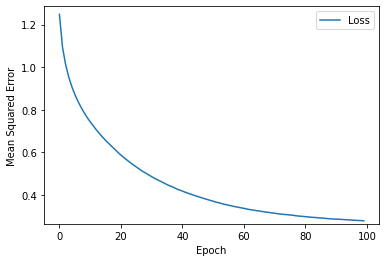


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
1/1 [==============================] - 0s 5ms/step - loss: 0.3497 - mean_squared_error: 0.3178


[0.3497476875782013, 0.31780192255973816]

In [471]:
# Hyperparameters.
learning_rate = 0.002
epochs = 100
batch_size = 1000
l2 = 0.1
label_name = "price"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer, l2)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

Data including demographics:   
**Training:** loss: 0.2409 - mean_squared_error: 0.2409   
**Validation:** loss: 0.4419 - mean_squared_error: 0.4419
  
---

Data excluding demographics:   
**Training:** loss: 0.2290 - mean_squared_error: 0.2290    
**Validation:** loss: 0.3215 - mean_squared_error: 0.3215  

---

The linear model appears to perform better without the demographic data. The
difference between training and validation metrics remains rather large. More stringent regularization may be advisable.

---

After Regularization of model with data excluding demographics:  
**Training:** loss: 0.3113 - mean_squared_error: 0.2792  
**Validation:** loss: 0.3497 - mean_squared_error: 0.3178